In [1]:
import numpy as np
import rebound
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from celmech.disturbing_function import df_coefficient_Ctilde
from celmech.disturbing_function import evaluate_df_coefficient_dict

In [2]:
def wrapRad(theta, k):
    return (theta + k*np.pi) % (2*k*np.pi) - k*np.pi

$$ param: \qquad
r = \frac{j_2}{j_1},\qquad
\epsilon_1 = \mu_1 |C_1| e^{k_1},\qquad
\epsilon_2 = \mu_2 |C_2| e^{k_2}, \qquad
\nu = \frac{1}{\sqrt{3}}\frac{n_{r2}-n_{r1}}{n_{r1}} = \frac{1}{\sqrt{3}}\left(\frac{j_1(j_2+k_2)}{j_2(j_1-k_1)}\frac{n_2}{n_1}-1\right)$$

In [3]:
def param2OE(param, userDefined):
    r, nu, epsilon1, epsilon2 = param
    ecc, P1, j1, k1, k2 = userDefined
    
    j2 = r*j1
    
    #calculate C1 and C2
    coeff1 = (j1,-(j1-k1),0,-k1,0,0)
    C1 = df_coefficient_Ctilde(*coeff1,*(0,0,0,0))
    alpha1 = ((j1-k1)/j1)**(2/3)
    Cval1 = evaluate_df_coefficient_dict(C1,alpha1)

    coeff2 = (j2+k2,-j2,-k2,0,0,0)
    C2 = df_coefficient_Ctilde(*coeff2,*(0,0,0,0))
    alpha2 = (j2/(j2+k2))**(2/3)
    Cval2 = evaluate_df_coefficient_dict(C2,alpha2)

    # get mu1 and mu2
    mu1 = epsilon1 / (abs(Cval1) * ecc**k1)
    mu2 = epsilon2 / (abs(Cval2) * ecc**k2)
    
    # get P2
    P2 = P1 * j1*(j2+k2) / (j2*(j1-k1)*(np.sqrt(3)*nu + 1))

    return mu1, mu2, P1, P2

In [4]:
def OE2param(OE, userDefined):
    ecc, P1, P2, mu1, mu2 = OE
    j1, k1, j2, k2 = userDefined
    
    # get r
    r = j2/j1

    # calculate C1 and C2
    coeff1 = (j1,-(j1-k1),0,-k1,0,0)
    C1 = df_coefficient_Ctilde(*coeff1,*(0,0,0,0))
    alpha1 = ((j1-k1)/j1)**(2/3)
    Cval1 = evaluate_df_coefficient_dict(C1,alpha1)

    coeff2 = (j2+k2,-j2,-k2,0,0,0)
    C2 = df_coefficient_Ctilde(*coeff2,*(0,0,0,0))
    alpha2 = (j2/(j2+k2))**(2/3)
    Cval2 = evaluate_df_coefficient_dict(C2,alpha2)

    # get epsilon1 and epsilon2
    epsilon1 = mu1 * abs(Cval1) * ecc**k1
    epsilon2 = mu2 * abs(Cval2) * ecc**k2

    # get nu
    n1 = 2*np.pi/P1
    n_r1 = (j1-k1) * n1 / j1
    n2 = 2*np.pi/P2
    n_r2 = (j2+k2) * n2 / j2
    nu = 1/np.sqrt(3) * (n_r2/n_r1 - 1)
    
    return r, nu, epsilon1, epsilon2

$$ ICs: \qquad
\phi = j_1(\lambda-n_{r1}t),\qquad 
p = -\sqrt{3}\left[\left(\frac{n_{r1}}{2\pi/P_0}\right)^{1/3}-1\right]$$

In [5]:
def param2OE_IC(j1, k1, P1, IC):
    n_r1 = (j1-k1)*2*np.pi / (j1*P1)
    return [[phi_0/j1 ,(1-p_0/np.sqrt(3))**3 * (2*np.pi/n_r1)] for phi_0, p_0 in IC]

def OE2param_IC(j1, k1, P1, IC):
    n_r1 = (j1-k1)*2*np.pi / (j1*P1)
    return [[j1*lambda_0, -np.sqrt(3) * ((n_r1 / (2*np.pi/P_0))**(1/3) - 1)] for lambda_0, P_0 in IC]

In [46]:
nu = 0.001
j1, j2, k1, k2 = 5, 5, 1, 1
mu1, mu2, P1, P2 = 3.06094560257218e-07, 1.1220466311727213e-07, 1, 1.4974064160078948

In [54]:
# set lambda_0 and P_0
ic_param = [[x,y] for x in np.linspace(-np.pi/4, np.pi/4, 4) for y in np.linspace(-0.5*nu, 1.5*nu, 18)]
ic_OE = param2OE_IC(j1, k1, P1, ic_param)

Text(0.5, 1.0, '$e_{12}$=$e_{23}=0.05$')

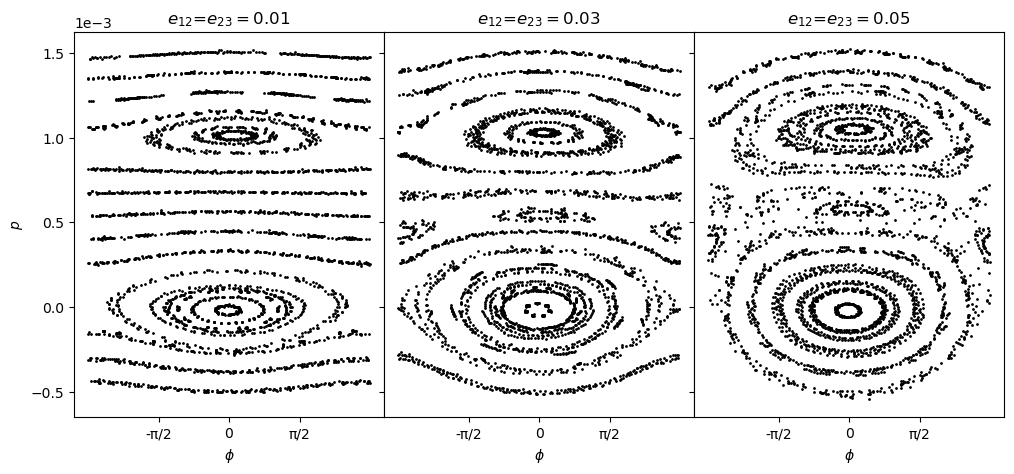

In [56]:
span = 1
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(12,5))
f.subplots_adjust(wspace=0)

ecc = 0.01
n_r1 = (j1-k1) * 2*np.pi / (j1*P1)
n_r2 = (j2+k2) * 2*np.pi / (j2*P2)
pomega0 = 0
    
for lambda_0, P_0 in ic_OE:
    # start simulation
    sim = rebound.Simulation()
    sim.units = ('yr', 'AU', 'Msun')

    # add star, planet 1, planet 2
    sim.add(m=1.)
    sim.add(m=mu1, P=P1, l=-np.pi/(j1-k1))
    sim.add(m=mu2, P=P2, l=-(k2+1)%2*np.pi/(j2+k2))
    ps = sim.particles
    ps[1].r = ps[1].a*(ps[1].m/3/ps[0].m)**(1/3)
    ps[2].r = ps[2].a*(ps[2].m/3/ps[0].m)**(1/3)
    
    # add test particle
    sim.add(P=P_0, l=lambda_0, e=ecc, pomega=pomega0)
    sim.move_to_com()
    sim.integrator = "whfast"
    sim.dt = sim.particles[1].P/20
    sim.collision = "direct"
    
    # track how system developes in time
    num = 51
    phi, p = np.zeros(num), np.zeros(num)
    
    time_rescaled = np.linspace(0,num-1,num)* 2*np.pi/(r*nu)
    info = sim.particles[3].calculate_orbit(primary=sim.particles[0])
    for i,t_r in enumerate(time_rescaled):
        try:
            t_unscaled = (t_r + (k2+r*k1)*info.pomega/(r*nu))/(np.sqrt(3)*j1*n_r1)
            sim.integrate(t_unscaled)
        except rebound.Collision:
            print('Collision')
        info = sim.particles[3].calculate_orbit(primary=sim.particles[0])
        
        phi[i] = wrapRad(j1*(info.l - n_r1*t_unscaled) - k1*info.pomega, span)
        p[i] = -np.sqrt(3)*((n_r1 / info.n)**(1/3) - 1)
    ax1.scatter(phi,p,[1],color='black')
ax1.set_ylabel(r'$p$')
ax1.ticklabel_format(axis='y',scilimits=(-3,-3))
ax1.set_xlabel(r'$\phi$')
ax1.set_xticks(np.arange(-np.pi/2, np.pi, step=(np.pi/2)), ['-π/2', '0', 'π/2'])
ax1.set_title('$e_{12}$=$e_{23}=0.01$')


#-------------------------------------Hamiltonian---------------------------------------------
ecc = 0.03
n_r1 = (j1-k1) * 2*np.pi / (j1*P1)
n_r2 = (j2+k2) * 2*np.pi / (j2*P2)
pomega0 = 0
    
for lambda_0, P_0 in ic_OE:
    # start simulation
    sim = rebound.Simulation()
    sim.units = ('yr', 'AU', 'Msun')

    # add star, planet 1, planet 2
    sim.add(m=1.)
    sim.add(m=mu1, P=P1, l=-np.pi/(j1-k1))
    sim.add(m=mu2, P=P2, l=-(k2+1)%2*np.pi/(j2+k2))
    ps = sim.particles
    ps[1].r = ps[1].a*(ps[1].m/3/ps[0].m)**(1/3)
    ps[2].r = ps[2].a*(ps[2].m/3/ps[0].m)**(1/3)
    
    # add test particle
    sim.add(P=P_0, l=lambda_0, e=ecc, pomega=pomega0)
    sim.move_to_com()
    sim.integrator = "whfast"
    sim.dt = sim.particles[1].P/20
    sim.collision = "direct"
    
    # track how system developes in time
    phi, p = np.zeros(num), np.zeros(num)
    
    time_rescaled = np.linspace(0,num-1,num)* 2*np.pi/(r*nu)
    info = sim.particles[3].calculate_orbit(primary=sim.particles[0])
    for i,t_r in enumerate(time_rescaled):
        try:
            t_unscaled = (t_r + (k2+r*k1)*info.pomega/(r*nu))/(np.sqrt(3)*j1*n_r1)
            sim.integrate(t_unscaled)
        except rebound.Collision:
            print('Collision')
        info = sim.particles[3].calculate_orbit(primary=sim.particles[0])
        
        phi[i] = wrapRad(j1*(info.l - n_r1*t_unscaled) - k1*info.pomega, span)
        p[i] = -np.sqrt(3)*((n_r1 / info.n)**(1/3) - 1)
    ax2.scatter(phi,p,[1],color='black')
ax2.set_xlabel('$\phi$')
ax2.set_xticks(np.arange(-np.pi/2, np.pi, step=(np.pi/2)), ['-π/2', '0', 'π/2'])
ax2.set_title('$e_{12}$=$e_{23}=0.03$')

#-----------------------------------------------------------------------------------
ecc = 0.05
n_r1 = (j1-k1) * 2*np.pi / (j1*P1)
n_r2 = (j2+k2) * 2*np.pi / (j2*P2)
pomega0 = 0
    
for lambda_0, P_0 in ic_OE:
    # start simulation
    sim = rebound.Simulation()
    sim.units = ('yr', 'AU', 'Msun')

    # add star, planet 1, planet 2
    sim.add(m=1.)
    sim.add(m=mu1, P=P1, l=-np.pi/(j1-k1))
    sim.add(m=mu2, P=P2, l=-(k2+1)%2*np.pi/(j2+k2))
    ps = sim.particles
    ps[1].r = ps[1].a*(ps[1].m/3/ps[0].m)**(1/3)
    ps[2].r = ps[2].a*(ps[2].m/3/ps[0].m)**(1/3)
    
    # add test particle
    sim.add(P=P_0, l=lambda_0, e=ecc, pomega=pomega0)
    sim.move_to_com()
    sim.integrator = "whfast"
    sim.dt = sim.particles[1].P/20
    sim.collision = "direct"
    
    # track how system developes in time
    phi, p = np.zeros(num), np.zeros(num)
    
    time_rescaled = np.linspace(0,num-1,num)* 2*np.pi/(r*nu)
    info = sim.particles[3].calculate_orbit(primary=sim.particles[0])
    for i,t_r in enumerate(time_rescaled):
        try:
            t_unscaled = (t_r + (k2+r*k1)*info.pomega/(r*nu))/(np.sqrt(3)*j1*n_r1)
            sim.integrate(t_unscaled)
        except rebound.Collision:
            print('Collision')
        info = sim.particles[3].calculate_orbit(primary=sim.particles[0])
        
        phi[i] = wrapRad(j1*(info.l - n_r1*t_unscaled) - k1*info.pomega, span)
        p[i] = -np.sqrt(3)*((n_r1 / info.n)**(1/3) - 1)
    ax3.scatter(phi,p,[1],color='black')
ax3.set_xlabel('$\phi$')
ax3.set_xticks(np.arange(-np.pi/2, np.pi, step=(np.pi/2)), ['-π/2', '0', 'π/2'])
ax3.set_title('$e_{12}$=$e_{23}=0.05$')